# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [19]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [20]:
# These are all of the files you are given
#df_tr = pd.read_csv("archive/train.csv")


In [21]:
#df_tr.head()
# avg = df_tr['LEN'].mean()
# print(avg)

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [22]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [23]:
from datetime import datetime
import math
def parse_time(x):
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.timetuple().tm_yday

# year, month, day, hour, weekday, dayOfYear = parse_time(1408048611)
# Because we are assigning multiple values at a , wetime need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return (dt.hour * 60 + dt.minute) / 1440

metadata = pd.read_csv('archive/metaData_taxistandsID_name_GPSlocation.csv')
longlatTable = []
for i in range(0, 63):
    longlatTable.append([metadata[i:i+1].Latitude.values[0], metadata[i:i+1].Longitude.values[0]])

maxLat = np.max(np.array(longlatTable)[:, 0])
minLat = np.min(np.array(longlatTable)[:, 0])
maxLong = np.max(np.array(longlatTable)[:, 1])
minLong = np.min(np.array(longlatTable)[:, 1])

# print(minLong, maxLong, minLat, maxLat)
# print(longlatTable)
def parse_origin_cal_lat_long(x):
    if math.isnan(x['ORIGIN_STAND']):
        return 0, 0
    lat, long = longlatTable[ round(x['ORIGIN_STAND']) - 1][0], longlatTable[round(x['ORIGIN_STAND']) - 1][1]
    
    return (lat - minLat) / (maxLat - minLat), (long - minLong) / (maxLong - minLong)

In [24]:
def onehot(x):
    x=x.values[0]
    if x=="A":
        return 1, 0, 0
    elif x=="B":
        return 0, 1, 0
    elif x=="C":
        return 0, 0, 1
    else:
        return 0, 0, 0
    
# df_tr[["CALL_A", "CALL_B", "CALL_C"]] = df_tr[["CALL_TYPE"]].apply(onehot, axis=1, result_type="expand")   
# df_tr[["DAY_A", "DAY_B", "DAY_C"]] = df_tr[["DAY_TYPE"]].apply(onehot, axis=1, result_type="expand")     


### Create a Prediction File

In [25]:
# vals = df_tr["HR"].value_counts()
# print(vals)
# def reduce(x):
#     return x - 2013
# hr_oh = torch.nn.functional.one_hot(torch.tensor(df_tr["HR"].values))
# print(hr_oh)
# print(hr_oh.shape)

In [26]:
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))

# # df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(reduce)
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))
# oh = torch.nn.functional.one_hot(torch.tensor(df_tr["TAXI_ID"].values))
# print(oh)
# print(oh.shape)


In [27]:
# df_tr[["CALL_A", "LEN"]].values

In [81]:
# Feature Trimming
# mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
# median = df_tr["LEN"].median()
# outlier_threshold = 3
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
# df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
# print("Before Trimming: " + str(len(df_tr)))
# print("After Trimming: " + str(len(df_trimmed)))

# df_tr = df_trimmed

testcsvv = pd.read_csv('archive/test_public.csv')
testcsvv[["YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR']] = testcsvv[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

unique_test_dates = np.array(testcsvv['DAYOFYEAR'].value_counts().keys())
unique_taxi_ids = np.array(testcsvv['TAXI_ID'].value_counts().keys())
unique_OC = np.array(testcsvv['ORIGIN_CALL'].value_counts().keys())
unique_OS = np.array(testcsvv['ORIGIN_STAND'].value_counts().keys())

print(unique_test_dates)
def parse_booleans(x):
  weekend = x.WK == 5 or x.WK == 6
  isuniqueday = x.DAYOFYEAR in unique_test_dates
  isuniquetaxi = x.TAXI_ID in unique_taxi_ids
  isOC = x.ORIGIN_CALL in unique_OC
  isOS = x.ORIGIN_STAND in unique_OS
  return int(weekend), int(isuniqueday), int(isuniquetaxi), int(isOS), int(isOC)

[273 279 226 305 355]


In [82]:
loaded_train = pd.read_csv("archive/train.csv").sample(frac=.5)
testcsvv = pd.read_csv("archive/test_public.csv")
testOC = testcsvv['ORIGIN_CALL'].values
df_tr = loaded_train.copy(deep=True)
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
outlier_threshold = 3
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
df_trimmed = df_trimmed[df_trimmed['LEN'] > 25]
print("Before Trimming: " + str(len(df_tr)))
print("After Trimming: " + str(len(df_trimmed)))
df_tr = df_trimmed



trlen = len(df_tr)

df_ts = pd.read_csv("archive/test_public.csv")
df_ts["POLYLINE"]="trololololo"


df_both = pd.concat([df_tr, df_ts])
df_both["LEN"] = df_both["POLYLINE"].apply(polyline_to_trip_duration)
ocvc = df_both["ORIGIN_CALL"].value_counts()
def filterOC(x):
#     print(x)
    val = x.values[0]
    if pd.isnull(val):
        return float('nan')
    if(ocvc[val] > 1000 or val in testOC):
        return val
    return float('nan')

df_both["ORIGIN_CALL"] = df_both[["ORIGIN_CALL"]].apply(filterOC, axis = 1, result_type="expand")
print('1')
print(df_both["ORIGIN_CALL"].value_counts())
df_both[["YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR']] = df_both[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
print('1')
df_both["MIDMINS"] = df_both[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
print('1')
df_both[["LAT_ORIGIN", "LONG_ORIGIN"]] = df_both[["ORIGIN_STAND"]].apply(parse_origin_cal_lat_long, axis=1, result_type="expand")
print('1')
df_both[['IS_WEEKEND', 'IS_UNIQUE_DAY', 'TAXI_ID_IN_TEST_SET', 'ORIGIN_STAND_IN_TEST_SET', 'ORIGIN_CALL_IN_TEST_SET']] = df_both[["WK", 'DAYOFYEAR', 'TAXI_ID', 'ORIGIN_STAND', 'ORIGIN_CALL']].apply(parse_booleans, axis=1, result_type="expand")

#df_tr["MIDMINS"]=(df_tr["MIDMINS"]-df_tr["MIDMINS"].min())/(df_tr["MIDMINS"].max()-df_tr["MIDMINS"].min())
df_both = pd.get_dummies(data=df_both, columns=['CALL_TYPE', "ORIGIN_STAND", "ORIGIN_CALL"])

df_tr = df_both.iloc[:trlen]
df_ts = df_both.iloc[trlen:]






Before Trimming: 855335
After Trimming: 824883
1
2002.0     28356
63882.0     3155
2001.0      1202
14123.0      489
2024.0       395
           ...  
34007.0        1
44696.0        1
85698.0        1
31780.0        1
76232.0        1
Name: ORIGIN_CALL, Length: 62, dtype: int64
1
1
1


In [83]:
# np.array(df_tr.columns)
# import pandas as pd
df_tr.to_csv("df_tr.csv", index=None)
df_ts.to_csv("df_ts.csv", index=None)
# df_tr = pd.read_csv("df_tr.csv")

In [84]:
# df_ts = pd.read_csv("df_ts.csv")

In [85]:
df_tr.shape

(824883, 149)

In [86]:
acceptable_taxi_ids = []
dropped = 0
for val, cnt in df_tr['TAXI_ID'].value_counts().items():
#     print(val, cnt, np.mean(df_tr[df_tr['TAXI_ID'] == val]['LEN']))
    if np.mean(df_tr[df_tr['TAXI_ID'] == val]['LEN']) < 400:
        dropped += 1
    else:
        acceptable_taxi_ids.append(val)
        
print('Dropped count:  ' + str(dropped))
x_train_unfiltered_dropped_ids = df_tr[df_tr['TAXI_ID'].isin(acceptable_taxi_ids)]

Dropped count:  1


In [87]:
import numpy as np
def normalize(df_tr, features):
    for feature in features:
        print (feature)
        maxVal = np.max(df_tr[feature])
        minVal = np.min(df_tr[feature])
        if (maxVal == minVal):
            df_tr[feature] = 1.0
        else:
            df_tr[feature] = (df_tr[feature] - minVal) / (maxVal - minVal)
            
normalize(df_tr, ["MIDMINS", "YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR', 'LAT_ORIGIN', 'LONG_ORIGIN'])
normalize(df_ts, ["MIDMINS", "YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR', 'LAT_ORIGIN', 'LONG_ORIGIN'])

MIDMINS
YR
MON
DAY


/tmp/ipykernel_22119/2833014413.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr[feature] = (df_tr[feature] - minVal) / (maxVal - minVal)


HR
WK
DAYOFYEAR
LAT_ORIGIN
LONG_ORIGIN
MIDMINS
YR
MON
DAY
HR
WK
DAYOFYEAR
LAT_ORIGIN
LONG_ORIGIN


/tmp/ipykernel_22119/2833014413.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr[feature] = 1.0


In [88]:


# parse_booleans({'TIMESTAMP': 10990421})

In [94]:
# df_tr['IS_WEEKEND'] = df_tr['IS_WEEKEND'].astype('float64')
# df_tr['IS_UNIQUE_DAY'] = df_tr['IS_UNIQUE_DAY'].astype('float64')
# df_tr['TAXI_ID_IN_TEST_SET'] = df_tr['TAXI_ID_IN_TEST_SET'].astype('float64')
# df_tr['ORIGIN_STAND_IN_TEST_SET'] = df_tr['ORIGIN_STAND_IN_TEST_SET'].astype('float64')
# df_tr['ORIGIN_CALL_IN_TEST_SET'] = df_tr['ORIGIN_CALL_IN_TEST_SET'].astype('float64')

# df_both[['IS_WEEKEND', 'IS_UNIQUE_DAY', 'TAXI_ID_IN_TEST_SET', 'ORIGIN_STAND_IN_TEST_SET', 'ORIGIN_CALL_IN_TEST_SET']] = df_both[["WK", 'DAYOFYEAR', 'TAXI_ID', 'ORIGIN_STAND', 'ORIGIN_CALL']].apply(parse_booleans, axis=1, result_type="expand")
df_tr['ORIGIN_CALL_IN_TEST_SET'].value_counts()

0    794964
1     29919
Name: ORIGIN_CALL_IN_TEST_SET, dtype: int64

In [95]:

class MyDataset(Dataset):
  def __init__(self, df):

    boolcols = list(df.columns)
    badcols = ["TRIP_ID", 'MIDMINS',  'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', "TAXI_ID", "DAY_TYPE",
              "YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR', 'LAT_ORIGIN', 'LONG_ORIGIN',
              ] 
    
    for b in badcols:
#       print(b)
      boolcols.remove(b)
    # print(boolcols)
    
#     print(boolcols)
    
    boolz=df[boolcols].values
    intz = df[["MIDMINS", "YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR', 'LAT_ORIGIN', 'LONG_ORIGIN']].values
    # print(boolz)
    y=df["LEN"].values
    
    print(df[["MIDMINS", "YR", "MON", "DAY", "HR", "WK", 'DAYOFYEAR', 'LAT_ORIGIN', 'LONG_ORIGIN',
              'IS_WEEKEND', 'IS_UNIQUE_DAY', 'TAXI_ID_IN_TEST_SET', 'ORIGIN_STAND_IN_TEST_SET', 'ORIGIN_CALL_IN_TEST_SET']].dtypes)
    
    booltens = torch.tensor(boolz,dtype=torch.float32)
    inttens = torch.tensor(intz,dtype=torch.float32)
    # print(booltens.shape)
    # print(inttens.shape)
 
    self.x_train=torch.cat([booltens, inttens], dim=1)
    # print(self.x_train)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.df = df
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [96]:
from torch.utils.data import random_split
trds=MyDataset(df_tr)

# trds, valds = random_split(trds, [0.9, 0.1])
# print(len(trds), len(valds))
# val_loader=DataLoader(valds)
# trds.df


MIDMINS                     float64
YR                          float64
MON                         float64
DAY                         float64
HR                          float64
WK                          float64
DAYOFYEAR                   float64
LAT_ORIGIN                  float64
LONG_ORIGIN                 float64
IS_WEEKEND                    int64
IS_UNIQUE_DAY                 int64
TAXI_ID_IN_TEST_SET           int64
ORIGIN_STAND_IN_TEST_SET      int64
ORIGIN_CALL_IN_TEST_SET       int64
dtype: object


In [97]:
train_loader=DataLoader(trds,batch_size=256, shuffle=True)


In [102]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        neuron = 64
        self.dro = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(142, neuron)
        self.fc2 = nn.Linear(neuron, neuron)
        self.fc3 = nn.Linear(neuron, neuron)
        self.fc4 = nn.Linear(neuron, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        x = self.dro(x)
        x = F.relu(self.fc3(x))
        x = self.dro(x)
        x = self.fc4(x)
        # x = self.dro(x)
        return x



In [103]:
import torch.optim as optim
net = Net()
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=.0001)

trds.x_train[0]

tensor([1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [104]:
losses = []
total_loss = 0.0
iter = 0
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        iter += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = net(inputs)
        
        # loss = criterion(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        losses.append(total_loss / iter)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i % 2000):.3f}')
    print("Epoch: " + str(epoch + 1) + ", steps:" + str(iter))
    # epoch_loss = 0.0

print('Finished Training')
print(len(losses))


[1,  2000] loss: 620.688
[1,  3223] loss: 447.959
Epoch: 1, steps:3223
[2,  2000] loss: 439.417
[2,  3223] loss: 437.053
Epoch: 2, steps:6446
[3,  2000] loss: 433.167
[3,  3223] loss: 433.685
Epoch: 3, steps:9669
[4,  2000] loss: 431.621
[4,  3223] loss: 432.057
Epoch: 4, steps:12892
[5,  2000] loss: 430.069
[5,  3223] loss: 430.442
Epoch: 5, steps:16115
[6,  2000] loss: 428.643
[6,  3223] loss: 428.669
Epoch: 6, steps:19338
[7,  2000] loss: 427.232
[7,  3223] loss: 428.297
Epoch: 7, steps:22561
[8,  2000] loss: 426.429
[8,  3223] loss: 427.119
Epoch: 8, steps:25784


KeyboardInterrupt: 

MIDMINS                     float64
YR                          float64
MON                         float64
DAY                         float64
HR                          float64
WK                          float64
DAYOFYEAR                   float64
LAT_ORIGIN                  float64
LONG_ORIGIN                 float64
IS_WEEKEND                    int64
IS_UNIQUE_DAY                 int64
TAXI_ID_IN_TEST_SET           int64
ORIGIN_STAND_IN_TEST_SET      int64
ORIGIN_CALL_IN_TEST_SET       int64
dtype: object
    TRIP_ID  TRAVEL_TIME
0        T1   748.783630
1        T2   652.466553
2        T3   748.511780
3        T4   618.670837
4        T5   696.232117
..      ...          ...
315    T323   790.033997
316    T324   663.543762
317    T325   762.361572
318    T326   790.305908
319    T327   816.552551

[320 rows x 2 columns]
mean 708.8574314117432
std 65.0791465571354
median 714.3421936035156
min 537.7814331054688
max 899.4182739257812
----------


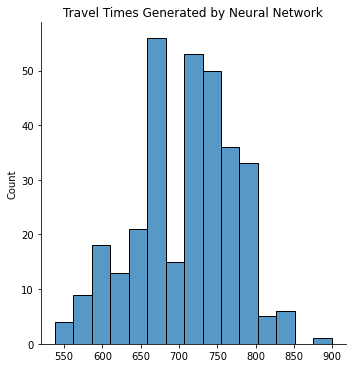

In [106]:
import seaborn as sns

testset = MyDataset(df_ts)
testloader = DataLoader(testset)
preds = []
net.eval()
with torch.no_grad():
    for data in testloader:
        features, labels = data
        # calculate outputs by running images through the network
        output = net(features)
        preds.append(output.item())

# preds = [630] * 320
# print(preds)
ids = testset.df["TRIP_ID"]
# print(preds)
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
newdf = pd.DataFrame(d)
print(newdf)
newdf.to_csv("normalizedFeaturesDidntOneHotEncodeEverything30EpochesAgain.csv", index=None)
labels = preds
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Neural Network')
#Try to include all the stats in your kaggle submissions and save the image / send to discord

In [ ]:
xRange = range(1, len(losses) + 1)

plt.plot(xRange, losses)

plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.title("RMSE Loss as Neural Network is Trained")
plt.legend()
plt.show()

In [ ]:
import ast
net.eval()
# Create a list to store the losses
data_point_losses = []

# Iterate over the dataset and compute the losses
with torch.no_grad():
    print(trds.df.shape)
    for i in range(trds.df.shape[0]):
        if i % 100000 == 0:
            print("i: ", i)
        # print(trds.df[i:i+1])
        input = trds.x_train[i]
        output = net(input)
        label = trds.y_train[i]
        # print(input)
        # print('output: ', output.item())
        # print('label: ', label.item())
        # print('loss: ', criterion(output.item(), label).item())
        loss = criterion(output, label)
        data_point_losses.append(loss.item())  # Append the loss value to the list

# Convert the losses to a tensor
loss_tensor = torch.tensor(data_point_losses)


In [ ]:
# Find the indices and values of the top 10 highest losses
top_loss_values, top_loss_indices = torch.topk(loss_tensor, k=10, largest=True)

# Print the indices and corresponding losses
for value, index in zip(top_loss_values, top_loss_indices):
    # print("Index:", index.item(), "Loss:", value.item())
    polyline = trds.df[index.item():index.item()+1]['POLYLINE'].values[0]
    polyline_array = ast.literal_eval(polyline)
    longitude_values = [row[0] for row in polyline_array]  # First column elements
    latitude_values = [row[1] for row in polyline_array]  # Second column elements
    print(polyline_array)
    plt.plot(longitude_values, latitude_values, label = str(index.item()), alpha=0.6)

    # print(x_vals)

# plt.plot()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.legend()
plt.title("Map of 10 Taxi Trips with Highest Training Error")
plt.show()



In [ ]:
# with torch.no_grad():
#     total_loss = 0.0
#     for i, data in enumerate(val_loader, 0):

#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data


#         # forward + backward + optimize
#         labels=labels
#         outputs = net(inputs)
        
#         loss = criterion(outputs, labels)


#         # print statistics
#         total_loss += loss.item()
#         # if i%1000==0:
#         #     print(round(loss.item()), outputs, labels)

# print(f'Total Loss: {total_loss / len(val_loader):.3f}')


In [ ]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

**Boosted Decision Trees**


In [ ]:
def processCSV(csvname):
  xg_train = pd.read_csv(csvname)
  df_tr = xg_train
  if "POLYLINE" not in df_tr: #test dataset
    df_tr["POLYLINE"]="[[["
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
  else: 
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
    mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
    median = df_tr["LEN"].median()
    outlier_threshold = 3
    print(mean, std)
    df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
    df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
    print("Before Trimming: " + str(len(df_tr)))
    print("After Trimming: " + str(len(df_trimmed)))
    df_tr = df_trimmed
    # first trim the dataset

  df_tr[["YR", "MON", "DAY", "HR", "WK", "DAYOFYEAR"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
  df_tr["MIDMINS"] = df_tr[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
  
  LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
  df_trimmed_copy = df_tr
  # print('there was ' + str(len(df_trimmed_copy['LEN'] == 0)) + " zeroes")
  # df_trimmed_copy = df_trimmed_copy[df_trimmed_copy['LEN'] != 0]
  y_train = df_trimmed_copy["LEN"]
  df_trimmed_copy["CALL_TYPE"] = df_trimmed_copy["CALL_TYPE"].map(LetterToIndex)
  # df_trimmed_copy["DAY_TYPE"] = df_trimmed_copy["DAY_TYPE"].map(LetterToIndex)
  #took out "TRIP_ID"
  # x_train = df_trimmed_copy[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "MIDMINS"]]
  return df_trimmed_copy, y_train

In [ ]:
x_train_unfiltered, y_train = processCSV('archive/train.csv')

In [ ]:
culled_set = x_train_unfiltered
testcsvv =pd.read_csv('archive/test_public.csv')

test_counts = testcsvv['ORIGIN_CALL'].value_counts()
culled_set = x_train_unfiltered[x_train_unfiltered['ORIGIN_CALL'].isin(np.array(test_counts.index))]


In [ ]:
testcsvv[["YR", "MON", "DAY", "HR", "WK", "DAYOFYEAR"]] = testcsvv[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
dayofyear = testcsvv['DAYOFYEAR'].value_counts()

culled_set = culled_set[culled_set['DAYOFYEAR'].isin(np.array(dayofyear.index))]
# culled_set.shape
print('mean', np.mean(culled_set['LEN']))
print('std', np.std(culled_set['LEN']))
print('median', np.median(culled_set['LEN']))
print('min', np.min(culled_set['LEN']))
print('max', np.max(culled_set['LEN']))
plt.hist(culled_set['LEN'])
plt.show()
print(culled_set.shape)

In [ ]:
with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered['DAYOFYEAR']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)
    # print(vals)


In [ ]:
with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered['TAXI_ID']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)

In [ ]:
with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered[x_train_unfiltered['LEN'] == 0]['TAXI_ID']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)

In [ ]:
a = max(x_train_unfiltered[x_train_unfiltered['DAYOFYEAR'] == 1]['LEN'])
print(a)
days = range(1, 366)
weekdays= range(0, 7)

daysInTest = [279, 273, 226, 304, 355, 272]
days_filtered = A = [i for i in days if i not in daysInTest]

dayvals = []
specialvals = []
for day in days:
    if day not in daysInTest:
        dayvals.append(np.mean(x_train_unfiltered[x_train_unfiltered['DAYOFYEAR'] == day]['LEN']))
    else:
        specialvals.append(np.mean(x_train_unfiltered[x_train_unfiltered['DAYOFYEAR'] == day]['LEN']))



In [ ]:
taxiIdValues = x_train_unfiltered['TAXI_ID'].value_counts()
taxiMin = min(x_train_unfiltered['TAXI_ID'])

x_axis_id_minus = []
y_axis_avg_len = []
for val, cnt in taxiIdValues.items():
    x_axis_id_minus.append(val - taxiMin)
    y_axis_avg_len.append(np.mean(x_train_unfiltered[x_train_unfiltered['TAXI_ID'] == val]['LEN']))


In [ ]:
for i in range(len(x_axis_id_minus)):
    if y_axis_avg_len[i] < 50:
        taxId = x_axis_id_minus[i] + taxiMin
        print(taxId, ": ")
        print(x_train_unfiltered[x_train_unfiltered['TAXI_ID'] == taxId]['LEN'].values)

        

In [ ]:
# plt.scatter(x_axis_id_minus, y_axis_avg_len)
# plt.xlabel('TAXI Id')
# plt.ylabel('LEN')
# plt.title('Date vs. TAxi ID')

# Display the plot
# plt.show()
# Create a scatter plot
plt.scatter(days_filtered, dayvals)
plt.scatter(daysInTest, specialvals, color='red')

plt.xlabel('Day of year')
plt.ylabel('LEN')


plt.title('Date vs. Trip length')

# Display the plot
plt.show()

print(daysInTest)
print(specialvals)

In [ ]:
x_train = x_train_unfiltered[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "HR", "WK", "DAYOFYEAR", "MIDMINS", "ORIGIN_"]]

In [ ]:
x_train.drop(columns=['TRIP_ID'])#this doesnt actually drop, just without tripid

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# shuffle_indices = np.random.permutation(len(x_train))
# X_shuffled = x_train[shuffle_indices]
# y_shuffled = y_train[shuffle_indices]

combined_df = pd.concat([x_train, y_train], axis=1)

# Get the number of rows in the DataFrame
num_rows = combined_df.shape[0]

# Generate a random permutation of indices
perm = np.random.permutation(num_rows)

# Shuffle the combined DataFrame using the permutation
shuffled_df = combined_df.iloc[perm]

shuffled_df['CALL_TYPE'] = shuffled_df['CALL_TYPE'].astype('category')
shuffled_df['ORIGIN_CALL'] = shuffled_df['ORIGIN_CALL'].astype('category')
shuffled_df['ORIGIN_STAND'] = shuffled_df['ORIGIN_STAND'].astype('category')
shuffled_df['TAXI_ID'] = shuffled_df['TAXI_ID'].astype('category')
shuffled_df['YR'] = shuffled_df['YR'].astype('category')
shuffled_df['MON'] = shuffled_df['MON'].astype('category')
shuffled_df['HR'] = shuffled_df['HR'].astype('category')
shuffled_df['WK'] = shuffled_df['WK'].astype('category')
shuffled_df['DAYOFYEAR'] = shuffled_df['DAYOFYEAR'].astype('category')

# Split the shuffled DataFrame back into separate DataFrames
shuffled_train_df = shuffled_df.iloc[:, :-1]
shuffled_label_df = shuffled_df.iloc[:, -1]

X_train, X_val, Y_train, Y_val = train_test_split(shuffled_train_df, shuffled_label_df, test_size=0.2, random_state=None)

# Assuming you have a DataFrame called 'df' with features and target variables

# Convert DataFrame to DMatrix
# feature_types = ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'q']

data_matrix = xgb.DMatrix(data = X_train.drop(columns=['TRIP_ID']), label=Y_train, enable_categorical=True)
validation_matrix = xgb.DMatrix(data = X_val.drop(columns=['TRIP_ID']), label=Y_val, enable_categorical=True)

parameters = {
    'objective': 'reg:squarederror',
    # 'colsample_bytree': 0.5586586280723452,
    # 'learning_rate': 0.06889888561468978,
    'max_depth': 6,
    # 'n_estimators': 1164,
    # 'reg_alpha': 25.287638310615133,
    # 'reg_lambda': 67.51702941180568,
    # 'subsample': 0.77179392553171
}

xg_model = xgb.train(parameters, data_matrix, num_boost_round=2000, early_stopping_rounds=10, evals=[(validation_matrix, 'validation')], verbose_eval=10)

In [ ]:
test_x, test_y = processCSV('archive/test_public.csv')
test_x = test_x.drop(columns=["DAY_TYPE", "MISSING_DATA", 'POLYLINE', 'LEN', 'TIMESTAMP', 'DAY'])
test_x

In [ ]:
test_x['CALL_TYPE'] = test_x['CALL_TYPE'].astype('category')
test_x['ORIGIN_CALL'] = test_x['ORIGIN_CALL'].astype('category')
test_x['ORIGIN_STAND'] = test_x['ORIGIN_STAND'].astype('category')
test_x['TAXI_ID'] = test_x['TAXI_ID'].astype('category')
test_x['YR'] = test_x['YR'].astype('category')
test_x['MON'] = test_x['MON'].astype('category')
test_x['HR'] = test_x['HR'].astype('category')
test_x['WK'] = test_x['WK'].astype('category')
test_x['DAYOFYEAR'] = test_x['DAYOFYEAR'].astype('category')
y_pred = xg_model.predict(xgb.DMatrix(test_x.drop(columns=['TRIP_ID']), enable_categorical=True))
# y_pred

In [ ]:
import seaborn as sns
ids = test_x["TRIP_ID"].values
# print(ids)
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i]
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : y_pred}
newdf = pd.DataFrame(d)
# print(newdf)
newdf.to_csv("filteredToDayOfYearCategoricalBoostedSubmitTomorrow.csv", index=None)
labels = y_pred
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Boosted Decision Tree')



In [ ]:
testcsvv =pd.read_csv('archive/test_public.csv')
ids = test_x["TRIP_ID"].values
means = []
dayOfYearToMeanMap = {
    279: 649.5969399406257,
    273: 615.9071133347835,
    226: 753.1351183063512,
    304: 616.6265060240963,
    355: 733.6887668918919,
    272: 640.0439491445613,
#     305: 0
}
testcsvv[["YR", "MON", "DAY", "HR", "WK", "DAYOFYEAR"]] = testcsvv[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
for xid in ids:
    row = testcsvv[testcsvv['TRIP_ID'] == xid]['DAYOFYEAR'].values[0]
    print(xid,row)
    mean = dayOfYearToMeanMap[row]
    means.append(mean)

d = {"TRIP_ID" : ids, "TRAVEL_TIME" : y_preds}
newdf = pd.DataFrame(d)

newdf.to_csv("MeanOf6UniqueDays.csv", index=None)

In [ ]:
parse_time({'TIMESTAMP':1414814368})

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

In [ ]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

df_tr = x_train_unfiltered
# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();